# Naive Bayes baseline for DiaRetDB0

We convert the DiaRetDB0 fundus photographs into coarse grayscale grids and train a Gaussian Naive Bayes classifier that separates healthy eyes from those with any annotated lesion.

## Plan

1. Load annotations and derive binary labels (lesion vs. no lesion).
2. Turn every image into a small `(64×64)` grayscale vector to obtain manageable numerical features.
3. Train/evaluate `GaussianNB` using the predefined splits to understand how much data is needed.
4. Inspect predictions and highlight improvement ideas.

In [15]:
from pathlib import Path
from functools import lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import cv2

plt.style.use('seaborn-v0_8')

In [16]:
def find_data_root() -> Path:
    notebook_dir = Path.cwd()
    candidates = [
        notebook_dir / 'diabetes_retinopathy/diaretdb0_v_1_1',
        notebook_dir / 'src/diabetes/diabetes_retinopathy/diaretdb0_v_1_1',
        notebook_dir.parent / 'diabetes_retinopathy/diaretdb0_v_1_1',
        notebook_dir.parent / 'src/diabetes/diabetes_retinopathy/diaretdb0_v_1_1',
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    raise FileNotFoundError('DiaRetDB0 folder not found; please update the search paths above.')

DATA_ROOT = find_data_root()
IMG_DIR = DATA_ROOT / 'resources/images/diaretdb0_fundus_images'
GT_DIR = DATA_ROOT / 'resources/images/diaretdb0_groundtruths'
TRAIN_SPLITS = DATA_ROOT / 'resources/traindatasets'
TEST_SPLITS = DATA_ROOT / 'resources/testdatasets'
IMAGE_SIZE = (64, 64)

for path in [IMG_DIR, GT_DIR, TRAIN_SPLITS, TEST_SPLITS]:
    if not path.exists():
        raise FileNotFoundError(path)
print('Ready:', IMG_DIR)


Ready: /home/ruben/EC/src/diabetes/diabetes_retinopathy/diaretdb0_v_1_1/resources/images/diaretdb0_fundus_images


In [17]:
def load_annotations(groundtruth_dir: Path) -> dict[str, list[str]]:
    annotations = {}
    for gt_path in sorted(groundtruth_dir.glob('image*.dot')):
        tokens = [token.strip().lower() for token in gt_path.read_text().split()]
        lesions = [token for token in tokens if token != 'n/a']
        annotations[gt_path.stem] = lesions
    return annotations

annotations = load_annotations(GT_DIR)
labels = {image_id: int(bool(lesions)) for image_id, lesions in annotations.items()}
label_series = pd.Series(labels, name='label')
label_series.replace({0: 'healthy', 1: 'retinopathy'}).value_counts()

label
retinopathy    108
healthy         22
Name: count, dtype: int64

In [18]:
def read_ids(path: Path) -> list[str]:
    return [line.strip() for line in path.read_text().splitlines() if line.strip()]

def apply_clahe(img_array: np.ndarray) -> np.ndarray:
    """Apply Contrast Limited Adaptive Histogram Equalization"""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img_array)

def augment_image(img: Image.Image, augmentation_type: str) -> Image.Image:
    """Apply various augmentations to an image"""
    if augmentation_type == 'original':
        return img
    elif augmentation_type == 'flip_h':
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    elif augmentation_type == 'flip_v':
        return img.transpose(Image.FLIP_TOP_BOTTOM)
    elif augmentation_type == 'rotate_90':
        return img.rotate(90, expand=True)
    elif augmentation_type == 'rotate_180':
        return img.rotate(180, expand=True)
    elif augmentation_type == 'rotate_270':
        return img.rotate(270, expand=True)
    elif augmentation_type == 'clahe':
        # Apply CLAHE to grayscale
        gray = np.array(img.convert('L'))
        enhanced = apply_clahe(gray)
        return Image.fromarray(enhanced)
    elif augmentation_type == 'brightness':
        enhancer = ImageEnhance.Brightness(img)
        return enhancer.enhance(1.2)
    else:
        return img

@lru_cache(maxsize=None)
def image_vector(image_id: str, augmentation: str = 'original') -> np.ndarray:
    with Image.open(IMG_DIR / f'{image_id}.png') as img:
        augmented = augment_image(img, augmentation)
        array = np.array(augmented.convert('L').resize(IMAGE_SIZE), dtype=np.float32) / 255.0
    return array.ravel()


def vectorize(image_ids: list[str], augment: bool = False) -> tuple[np.ndarray, np.ndarray]:
    """Vectorize images with optional augmentation"""
    if not augment:
        X = np.vstack([image_vector(image_id) for image_id in image_ids])
        y = np.array([labels[image_id] for image_id in image_ids], dtype=np.int64)
    else:
        # Apply multiple augmentations per image
        augmentation_types = ['original', 'flip_h', 'rotate_90', 'rotate_270', 'clahe']
        X_list = []
        y_list = []
        for image_id in image_ids:
            for aug_type in augmentation_types:
                X_list.append(image_vector(image_id, aug_type))
                y_list.append(labels[image_id])
        X = np.vstack(X_list)
        y = np.array(y_list, dtype=np.int64)
    return X, y

### Quick sweep across all official splits

This table helps gauge how the amount of labeled data drives accuracy.

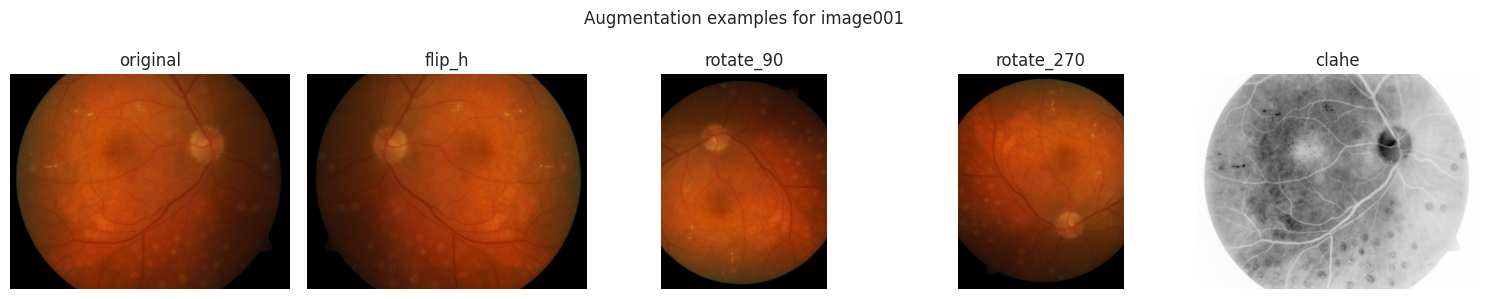

In [19]:
# Show augmentation examples
sample_id = list(annotations.keys())[0]
augmentation_types = ['original', 'flip_h', 'rotate_90', 'rotate_270', 'clahe']

fig, axes = plt.subplots(1, len(augmentation_types), figsize=(15, 3))
for ax, aug_type in zip(axes, augmentation_types):
    with Image.open(IMG_DIR / f'{sample_id}.png') as img:
        augmented = augment_image(img, aug_type)
        ax.imshow(augmented)
        ax.set_title(aug_type)
        ax.axis('off')
fig.suptitle(f'Augmentation examples for {sample_id}')
plt.tight_layout()

In [20]:
# Perform cross-validation comparison
all_image_ids = list(labels.keys())
all_labels = np.array([labels[img_id] for img_id in all_image_ids])

n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_results = []

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(all_image_ids, all_labels), 1):
    train_ids_cv = [all_image_ids[i] for i in train_idx]
    test_ids_cv = [all_image_ids[i] for i in test_idx]
    
    # Baseline: no augmentation
    X_train_base, y_train_base = vectorize(train_ids_cv, augment=False)
    X_test_cv, y_test_cv = vectorize(test_ids_cv, augment=False)
    
    model_base = GaussianNB()
    model_base.fit(X_train_base, y_train_base)
    y_pred_base = model_base.predict(X_test_cv)
    acc_base = accuracy_score(y_test_cv, y_pred_base)
    
    # With augmentation
    X_train_aug, y_train_aug = vectorize(train_ids_cv, augment=True)
    
    model_aug = GaussianNB()
    model_aug.fit(X_train_aug, y_train_aug)
    y_pred_aug = model_aug.predict(X_test_cv)
    acc_aug = accuracy_score(y_test_cv, y_pred_aug)
    
    cv_results.append({
        'fold': fold_idx,
        'train_samples': len(train_ids_cv),
        'test_samples': len(test_ids_cv),
        'baseline_accuracy': acc_base,
        'augmented_accuracy': acc_aug,
        'improvement': acc_aug - acc_base,
    })
    
    print(f"Fold {fold_idx}: Baseline={acc_base:.3f}, Augmented={acc_aug:.3f}, Δ={acc_aug-acc_base:+.3f}")

cv_df = pd.DataFrame(cv_results)
print(f"\n{'='*60}")
print(f"Mean baseline accuracy: {cv_df['baseline_accuracy'].mean():.3f} ± {cv_df['baseline_accuracy'].std():.3f}")
print(f"Mean augmented accuracy: {cv_df['augmented_accuracy'].mean():.3f} ± {cv_df['augmented_accuracy'].std():.3f}")
print(f"Mean improvement: {cv_df['improvement'].mean():+.3f} ± {cv_df['improvement'].std():.3f}")
cv_df

Fold 1: Baseline=0.615, Augmented=0.385, Δ=-0.231
Fold 2: Baseline=0.615, Augmented=0.538, Δ=-0.077
Fold 3: Baseline=0.615, Augmented=0.538, Δ=-0.077
Fold 4: Baseline=0.769, Augmented=0.538, Δ=-0.231
Fold 5: Baseline=0.462, Augmented=0.538, Δ=+0.077
Fold 6: Baseline=0.538, Augmented=0.615, Δ=+0.077
Fold 7: Baseline=0.615, Augmented=0.462, Δ=-0.154
Fold 8: Baseline=0.538, Augmented=0.692, Δ=+0.154
Fold 9: Baseline=0.538, Augmented=0.538, Δ=+0.000
Fold 10: Baseline=0.692, Augmented=0.692, Δ=+0.000

Mean baseline accuracy: 0.600 ± 0.087
Mean augmented accuracy: 0.554 ± 0.095
Mean improvement: -0.046 ± 0.132


,fold,train_samples,test_samples,baseline_accuracy,augmented_accuracy,improvement
0,1,117,13,0.615385,0.384615,-0.230769
1,2,117,13,0.615385,0.538462,-0.076923
2,3,117,13,0.615385,0.538462,-0.076923
3,4,117,13,0.769231,0.538462,-0.230769
4,5,117,13,0.461538,0.538462,0.076923
5,6,117,13,0.538462,0.615385,0.076923
6,7,117,13,0.615385,0.461538,-0.153846
7,8,117,13,0.538462,0.692308,0.153846
8,9,117,13,0.538462,0.538462,0.000000
9,10,117,13,0.692308,0.692308,0.000000


/tmp/ipykernel_95798/899272677.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([cv_df['baseline_accuracy'], cv_df['augmented_accuracy']],


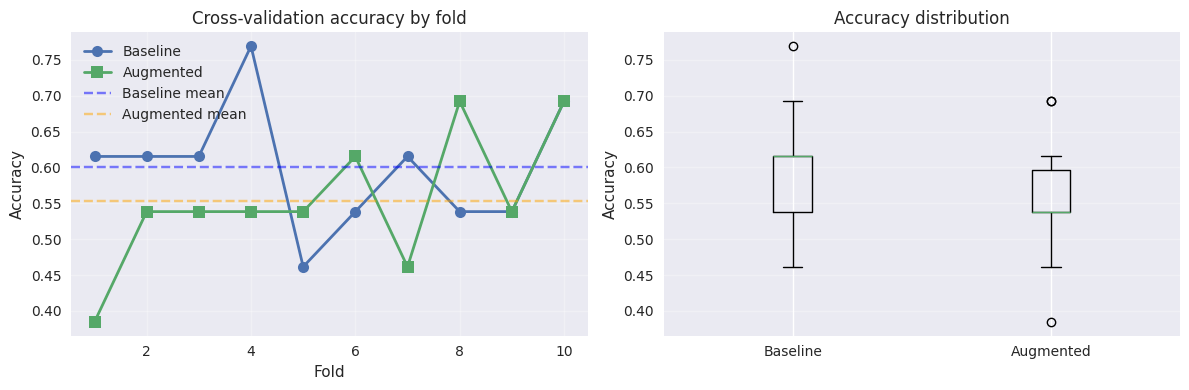

In [21]:
# Visualize cross-validation results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy comparison per fold
ax = axes[0]
x = cv_df['fold']
ax.plot(x, cv_df['baseline_accuracy'], 'o-', label='Baseline', linewidth=2, markersize=8)
ax.plot(x, cv_df['augmented_accuracy'], 's-', label='Augmented', linewidth=2, markersize=8)
ax.axhline(cv_df['baseline_accuracy'].mean(), color='blue', linestyle='--', alpha=0.5, label='Baseline mean')
ax.axhline(cv_df['augmented_accuracy'].mean(), color='orange', linestyle='--', alpha=0.5, label='Augmented mean')
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_title('Cross-validation accuracy by fold')
ax.legend()
ax.grid(True, alpha=0.3)

# Box plot comparison
ax = axes[1]
ax.boxplot([cv_df['baseline_accuracy'], cv_df['augmented_accuracy']], 
           labels=['Baseline', 'Augmented'])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy distribution')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

### Cross-validation with and without augmentation

Compare baseline vs augmented training using stratified k-fold cross-validation.

### Visualize augmented samples

Let's see how the augmentation transforms the images.

In [22]:
split_metrics = []
for split_idx in range(1, 10):
    train_ids = read_ids(TRAIN_SPLITS / f'traindata{split_idx}.txt')
    test_ids = read_ids(TEST_SPLITS / f'testdata{split_idx}.txt')
    
    # Baseline
    X_train, y_train = vectorize(train_ids, augment=False)
    X_test, y_test = vectorize(test_ids, augment=False)
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_baseline = accuracy_score(y_test, y_pred)
    
    # Augmented
    X_train_aug, y_train_aug = vectorize(train_ids, augment=True)
    model_aug = GaussianNB()
    model_aug.fit(X_train_aug, y_train_aug)
    y_pred_aug = model_aug.predict(X_test)
    acc_augmented = accuracy_score(y_test, y_pred_aug)
    
    split_metrics.append({
        'split': split_idx,
        'train_size': len(train_ids),
        'test_size': len(test_ids),
        'train_pos': int(y_train.sum()),
        'test_pos': int(y_test.sum()),
        'baseline_acc': acc_baseline,
        'augmented_acc': acc_augmented,
        'improvement': acc_augmented - acc_baseline,
    })

split_df = pd.DataFrame(split_metrics)
split_df

,split,train_size,test_size,train_pos,test_pos,baseline_acc,augmented_acc,improvement
0,1,10,120,7,101,0.783333,0.291667,-0.491667
1,2,20,110,15,93,0.618182,0.700000,0.081818
2,3,30,100,23,85,0.590000,0.380000,-0.210000
3,4,40,90,32,76,0.677778,0.477778,-0.200000
4,5,50,80,40,68,0.475000,0.250000,-0.225000
5,6,60,70,48,60,0.785714,0.614286,-0.171429
6,7,70,60,54,54,0.583333,0.350000,-0.233333
7,8,80,50,63,45,0.460000,0.380000,-0.080000
8,9,90,40,71,37,0.600000,0.775000,0.175000


### Detailed evaluation on the largest split

Split 9 keeps 90 images for training and 40 for testing, offering the most data for the naive Bayes baseline.

In [23]:
SPLIT_TO_ANALYZE = 9
train_ids = read_ids(TRAIN_SPLITS / f'traindata{SPLIT_TO_ANALYZE}.txt')
test_ids = read_ids(TEST_SPLITS / f'testdata{SPLIT_TO_ANALYZE}.txt')

X_train, y_train = vectorize(train_ids)
X_test, y_test = vectorize(test_ids)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
y_proba = nb_model.predict_proba(X_test)[:, 1]

print(f'Train set: {X_train.shape}, positives: {y_train.sum()}')
print(f'Test set:  {X_test.shape}, positives: {y_test.sum()}')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print('Classification report:')
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Retinopathy']))

Train set: (90, 4096), positives: 71
Test set:  (40, 4096), positives: 37
Accuracy: 0.600
Classification report:
              precision    recall  f1-score   support

     Healthy       0.07      0.33      0.11         3
 Retinopathy       0.92      0.62      0.74        37

    accuracy                           0.60        40
   macro avg       0.49      0.48      0.43        40
weighted avg       0.86      0.60      0.69        40



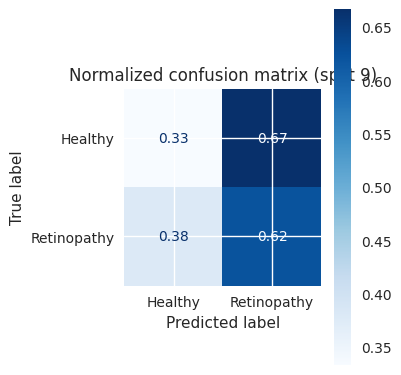

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=['Healthy', 'Retinopathy'],
    normalize='true',
    values_format='.2f',
    cmap='Blues',
    ax=ax,
)
ax.set_title('Normalized confusion matrix (split 9)')
plt.tight_layout()

In [25]:
results_df = (pd.DataFrame({
    'image_id': test_ids,
    'truth': y_test,
    'prediction': y_pred,
    'retinopathy_prob': y_proba,
})
.assign(
    truth_label=lambda df: df['truth'].map({0: 'Healthy', 1: 'Retinopathy'}),
    predicted_label=lambda df: df['prediction'].map({0: 'Healthy', 1: 'Retinopathy'}),
    error=lambda df: df['truth'] != df['prediction'],
))

results_df.sort_values('retinopathy_prob', ascending=False).head(10)

,image_id,truth,prediction,retinopathy_prob,truth_label,predicted_label,error
3,image012,1,1,1.0,Retinopathy,Retinopathy,False
2,image007,1,1,1.0,Retinopathy,Retinopathy,False
7,image024,1,1,1.0,Retinopathy,Retinopathy,False
5,image021,1,1,1.0,Retinopathy,Retinopathy,False
12,image083,1,1,1.0,Retinopathy,Retinopathy,False
11,image065,1,1,1.0,Retinopathy,Retinopathy,False
10,image055,1,1,1.0,Retinopathy,Retinopathy,False
9,image029,1,1,1.0,Retinopathy,Retinopathy,False
37,image045,1,1,1.0,Retinopathy,Retinopathy,False
36,image098,1,1,1.0,Retinopathy,Retinopathy,False


In [26]:
errors = results_df[results_df['error']]
errors

,image_id,truth,prediction,retinopathy_prob,truth_label,predicted_label,error
0,image001,1,0,2.361477e-122,Retinopathy,Healthy,True
1,image006,1,0,6.099385e-161,Retinopathy,Healthy,True
4,image017,1,0,1.179651e-08,Retinopathy,Healthy,True
6,image022,1,0,0.000000e+00,Retinopathy,Healthy,True
8,image028,1,0,3.273731e-116,Retinopathy,Healthy,True
20,image052,1,0,8.214728e-164,Retinopathy,Healthy,True
21,image071,1,0,7.965747e-92,Retinopathy,Healthy,True
22,image072,1,0,3.273731e-116,Retinopathy,Healthy,True
23,image074,1,0,4.431828e-214,Retinopathy,Healthy,True
27,image062,1,0,8.943395e-60,Retinopathy,Healthy,True


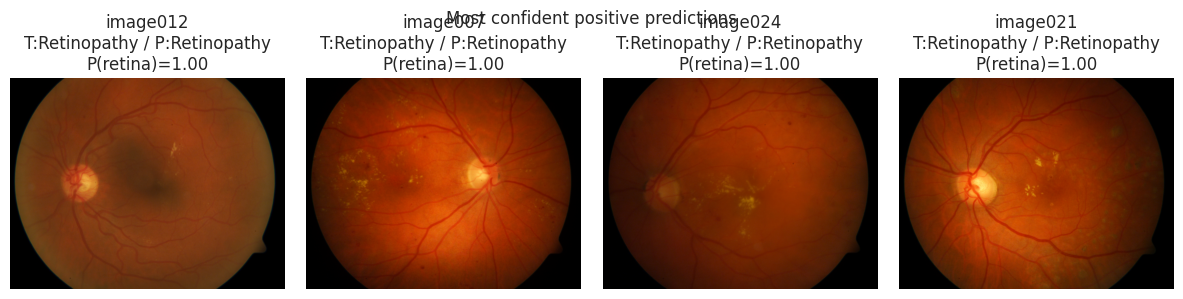

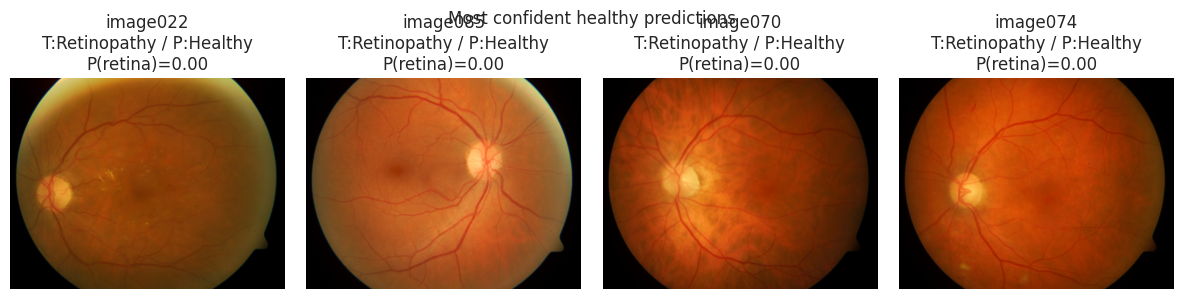

In [27]:
prediction_lookup = dict(zip(results_df['image_id'], results_df['prediction']))
prob_lookup = dict(zip(results_df['image_id'], results_df['retinopathy_prob']))


def show_predictions(sample_ids, title):
    fig, axes = plt.subplots(1, len(sample_ids), figsize=(3 * len(sample_ids), 3))
    for ax, image_id in zip(axes, sample_ids):
        with Image.open(IMG_DIR / f'{image_id}.png') as img:
            ax.imshow(img)
        truth = 'Retinopathy' if labels[image_id] else 'Healthy'
        pred = 'Retinopathy' if prediction_lookup[image_id] else 'Healthy'
        prob = prob_lookup[image_id]
        ax.set_title(f"{image_id}\nT:{truth} / P:{pred}\nP(retina)={prob:.2f}")
        ax.axis('off')
    fig.suptitle(title)
    plt.tight_layout()

show_predictions(results_df.sort_values('retinopathy_prob', ascending=False)['image_id'].head(4).tolist(),
                 'Most confident positive predictions')
show_predictions(results_df.sort_values('retinopathy_prob')['image_id'].head(4).tolist(),
                 'Most confident healthy predictions')


### Next steps

* Replace the handcrafted down-sampling with learned features (CNN backbone or color histogram statistics) to capture subtle cues.
* Perform proper cross-validation, possibly rebalancing the training set because DiaRetDB0 has only ~20 healthy eyes.
* Augment the training data (flips, rotations, CLAHE) before vectorization to improve robustness.